In [1]:
import autoencodeSVJ.utils as utils
import autoencodeSVJ.models as models
import autoencodeSVJ.trainer as trainer
import glob
import os
import numpy as np

Using TensorFlow backend.


### 1: load and normalize input data
we can use the data_loader for this. 
add an h5 sample, grab the table which represents it, and then split the table into training and testing datasets:

In [2]:
# get h5 datasets
data,jet_tables = utils.get_training_data_jets("../../data/dijet_tight/*data.h5")
data.head()

data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/0.0_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/7_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/8_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/6_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/5_data.h5'
data_loader :: Grabbing dataset with keys [u

,jetEta,jetPhi,jetPt,jetM,jetChargedFraction,jetPTD,jetAxis2
0,0.391208,3.126895,880.629578,46.972202,0.941176,0.238104,0.041430
1,0.226281,1.619783,839.069214,27.909035,0.631579,0.254852,0.016366
2,1.215448,0.042642,1736.550293,164.827713,0.608696,0.418112,0.006629
3,-0.121109,-1.891376,453.773132,62.488964,0.771429,0.162267,0.079624
4,1.025759,3.117460,882.341492,160.383484,0.600000,0.215028,0.021459


#### plotting
we'll also plot the input histograms here, to make sure there are no screaming discrepancies in the training and testing sets

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'train', 'test']


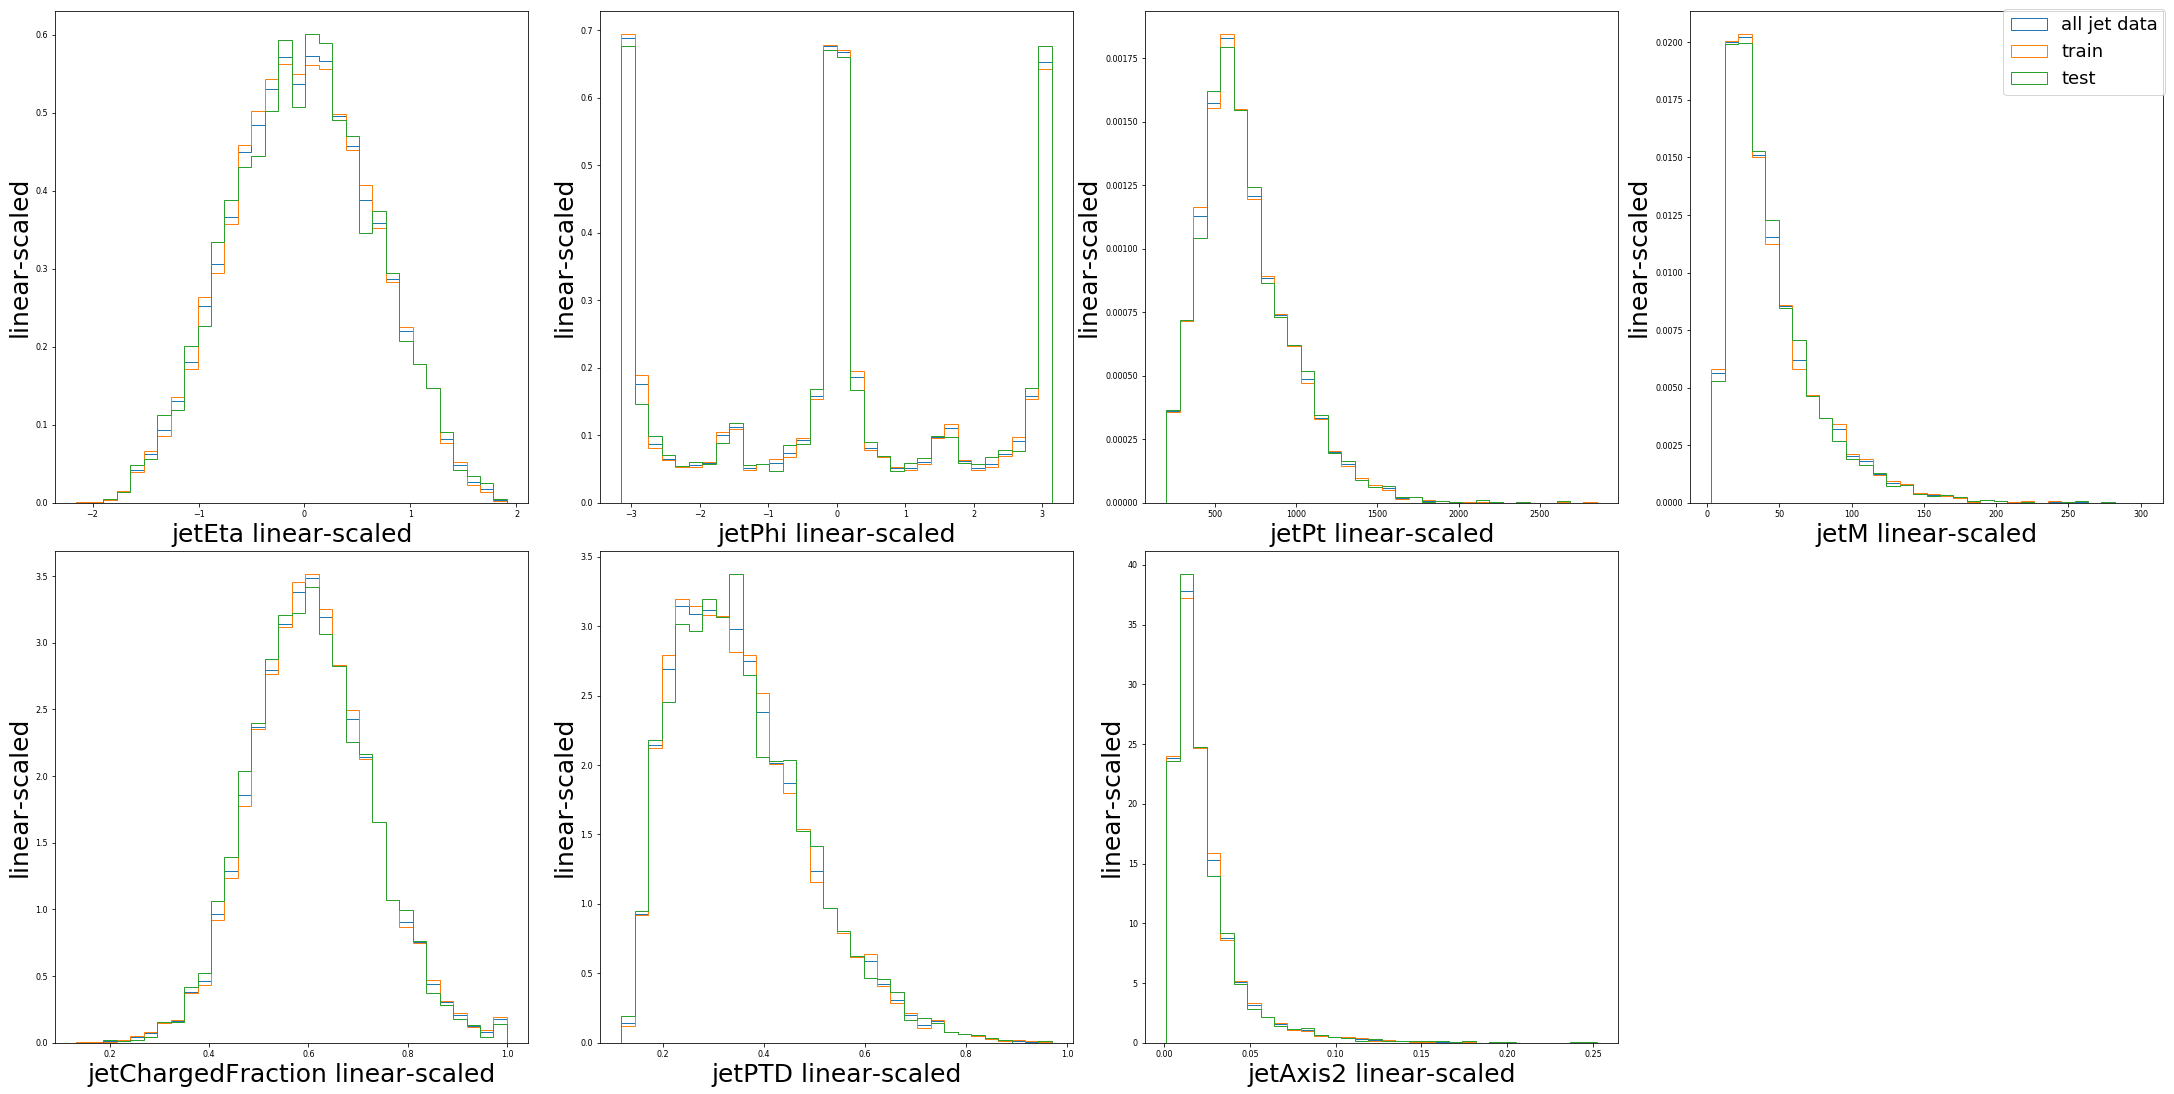

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'jet 0', 'jet 1']


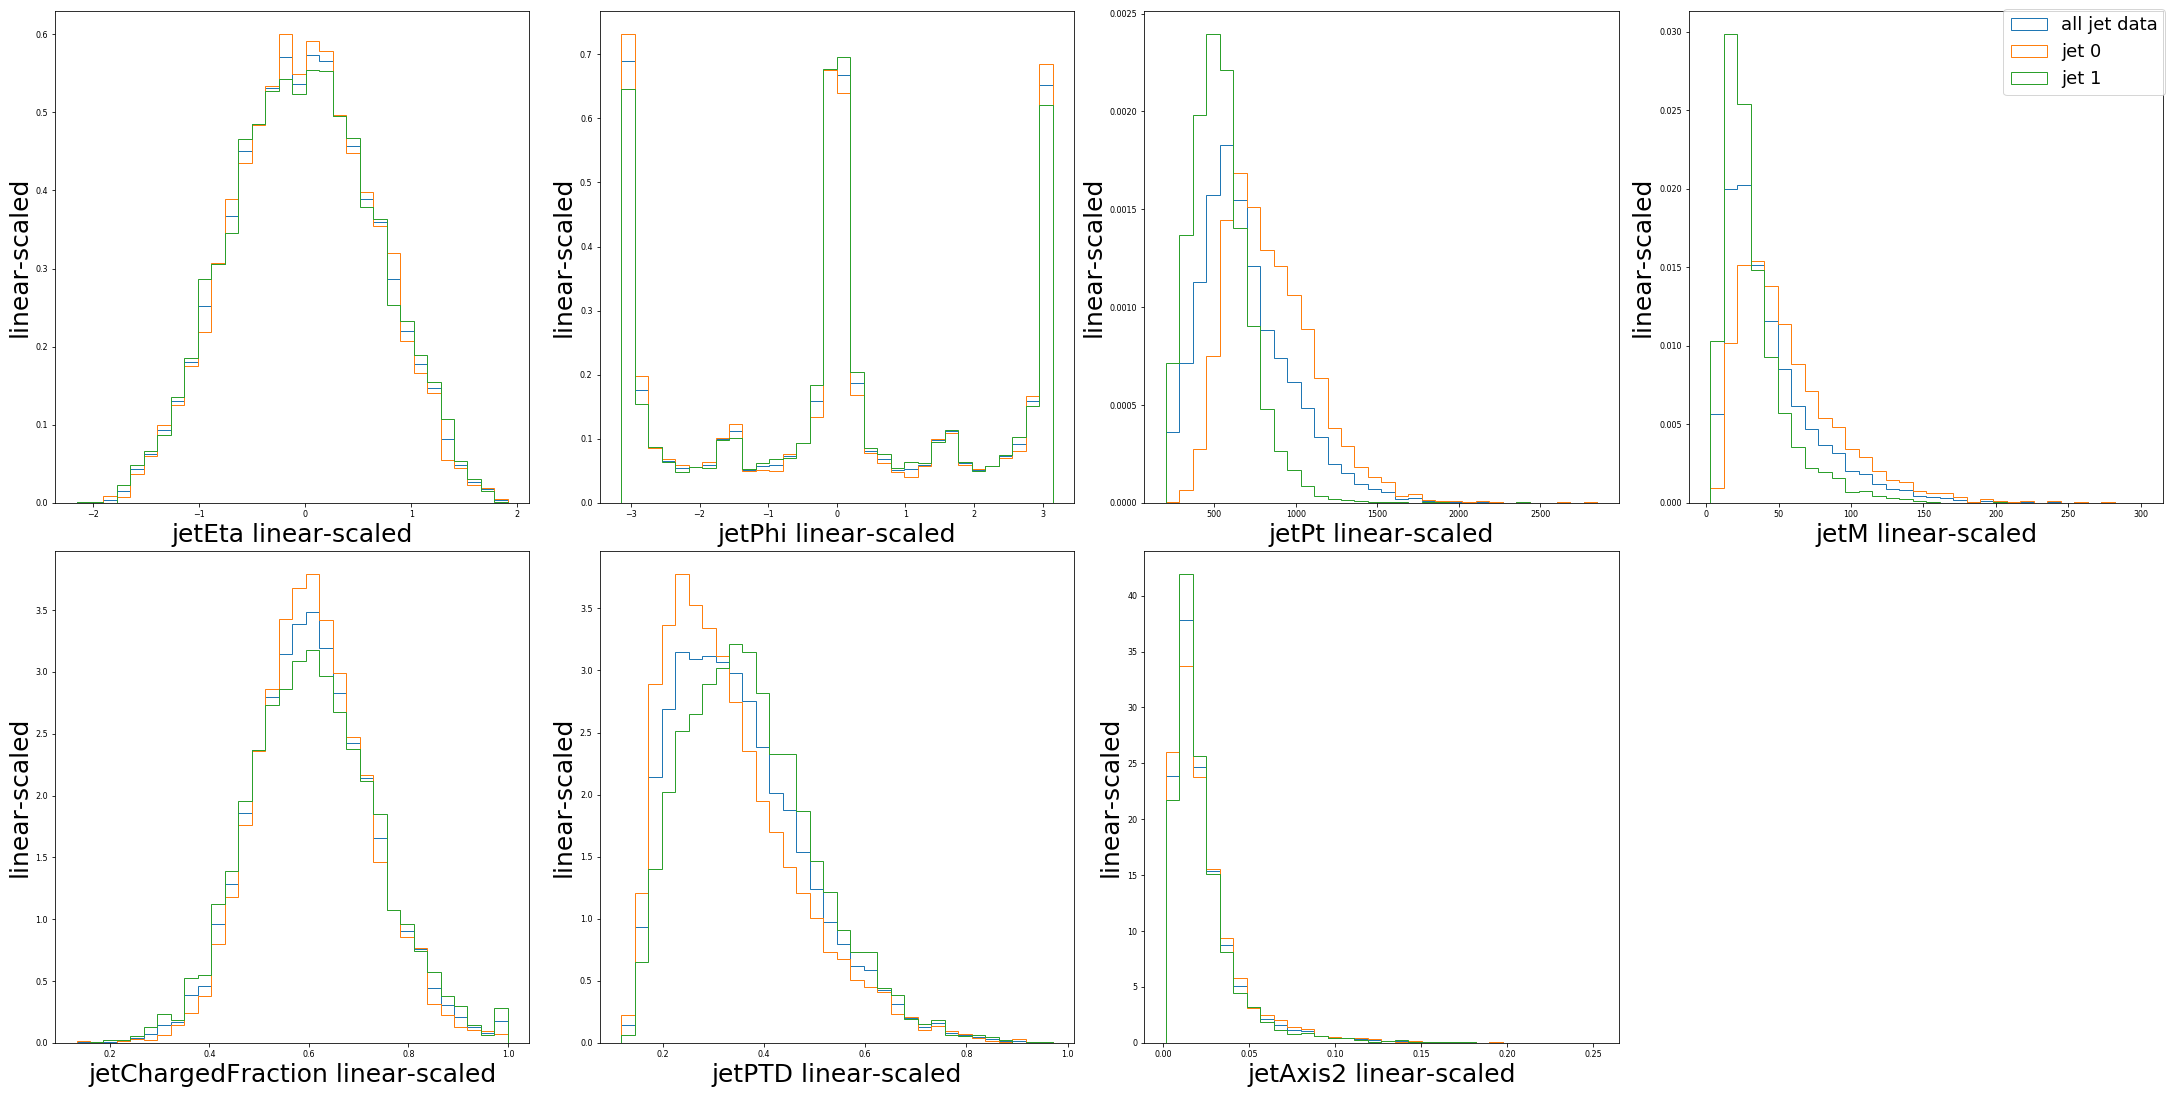

In [3]:
train, test = data.train_test_split(0.3)
data.plot([train, test], normed=1, bins=32, figsize=(30,15), fontsize=25, cols=4, alpha=1)
data.plot(jet_tables, normed=1, bins=32, figsize=(30,15), fontsize=25, cols=4, alpha=1)

We then get training/testing datasets, and normalize them to the main data set. We can check how the normalized features look compared with one another, to make sure that they are useful. This way we can decide what type of normalization to use.

data_table :: plotting distrubution(s) for table(s) ['jetEta', 'jetPhi', 'jetPt', 'jetM', 'jetChargedFraction', 'jetPTD', 'jetAxis2']


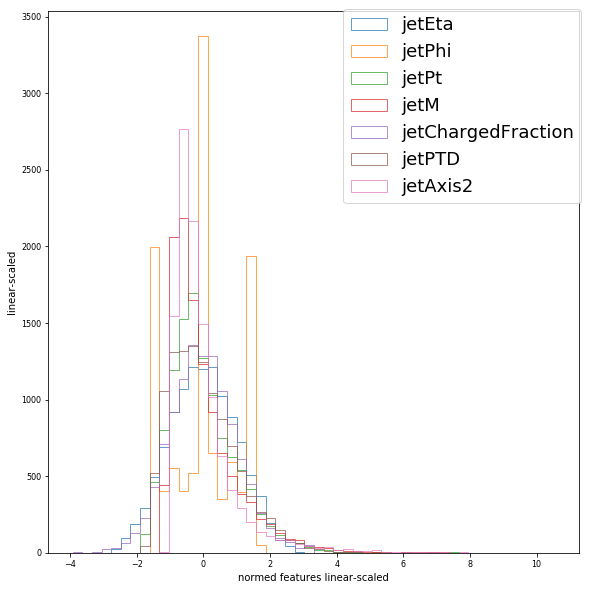

In [4]:
ntype="StandardScaler"
norm_args = {
    "norm_type": ntype
}
norm_data = data.norm(**norm_args)
features = [utils.data_table(norm_data[c].values.reshape(norm_data[c].shape[0],1), name=c, headers=["normed features"]) for c in norm_data]
features[0].plot(features[1:], bins=50, figsize=(8,8), fontsize=10)


# rmin, rmax = np.asarray([(data.median() - 2.*data.std()).values, (data.median() + 2.*data.std()).values])
# custom_norm = lambda x: (x - rmin) / (rmax - rmin)
# # norm_data = data.norm(norm_type=0, rng=rng)
# norm_data = custom_norm(data)
# features = [utils.data_table(norm_data[c].values.reshape(norm_data[c].shape[0],1), name=c, headers=["normed features"]) for c in norm_data]
# features[0].plot(features[1:], bins=50, figsize=(8,8), fontsize=10)

In [5]:
train_norm, test_norm = data.norm(train, **norm_args), data.norm(test, **norm_args)

### 2. build model 
To make our model, we'll use the simple "shallow" architecture defined in models.py. This gives us a decidedly shallow autoencoder with a bottleneck of our liking.

In [28]:
bn = 5
lambda_ = 0.000075 # 1-2 for 5 nodes, ?? for 4 
ae_skeleton = models.base_autoencoder()
ae_skeleton.add(7)
ae_skeleton.add(50)
ae_skeleton.add(bn, 'relu')
ae_skeleton.add(50)
ae_skeleton.add(7, "linear")
robust = models.robust_deep(base_ae=ae_skeleton, lambda_=lambda_*train.shape[0])
encoder, decoder = robust.AE.layers[1:]
autoencoder = robust.AE
name = "{}_{}".format(bn, lambda_)
instance = trainer.trainer(os.path.join("../data/training_runs/7jf/robust", name))

h5_elt 'metric_names' :: creating group 'data' in file '5_7.5e-05.h5'
h5_elt 'metric_names' :: creating dataset 'data/metric_names' in file '5_7.5e-05.h5'
h5_elt 'training' :: creating group 'params' in file '5_7.5e-05.h5'
h5_elt 'training' :: creating dataset 'params/training' in file '5_7.5e-05.h5'
h5_elt 'config' :: creating dataset 'params/config' in file '5_7.5e-05.h5'


... and the model summaries:

In [29]:
print('encoder summary:')
encoder.summary()
print('\n')
print('decoder summary:')
decoder.summary()
print('\n')
print('autoencoder summary:')
autoencoder.summary()


encoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
layer_2 (Dense)              (None, 50)                400       
_________________________________________________________________
layer_3 (Dense)              (None, 5)                 255       
Total params: 655
Trainable params: 655
Non-trainable params: 0
_________________________________________________________________


decoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_3 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
layer_4 (Dense)              (None, 50)                300       
__________________________________________

### 3. train model 
this can be most easily done using the `training_skeleton`, defined in `skeletons.py`. This helps with dynamic training and allows for stopping midway without losing history information, retraining models, etc.

In [30]:
# name = "medium_4_test"
# instance = trainer.trainer(os.path.join("../data/training_runs/7jf/mean_std_norm/", name))

training is easy:

In [33]:
from keras import backend as K

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return SS_res/(SS_tot + K.epsilon())

# train, test = data.train_test_split(0.25)
# ntype="RobustScaler"
# train_norm, test_norm = data.norm(train, norm_type=ntype), data.norm(test, norm_type=ntype)

robust = instance.train(
    x_train=data.norm(**norm_args).data,
#     x_test=test_norm.data,
#     y_train=train_norm.data,
#     y_test=test_norm.data,
    optimizer="adam",
    loss='mse',
    epochs=5,
    model=robust,
    metrics=[r_square, "mae", "mse"],
    force=True,
    batch_size=32,
    use_callbacks=False,
    learning_rate=0.001,
)

train_shell :: using model passed as function argument
train_shell :: TRAINING EPOCH 10/15
robust_deep_ae :: 16.64 % OUTLIERS
Train on 11236 samples, validate on 0 samples
Epoch 11/11
351/351 [==============================] - 6s 17ms/step - loss: 0.0307 - r_square: 0.9693 - mean_absolute_error: 0.0953 - mean_squared_error: 0.0307
train_shell :: TRAINING EPOCH 11/15
robust_deep_ae :: 16.55 % OUTLIERS
Train on 11236 samples, validate on 0 samples
Epoch 12/12
351/351 [==============================] - 5s 15ms/step - loss: 0.0305 - r_square: 0.9695 - mean_absolute_error: 0.0941 - mean_squared_error: 0.0305
train_shell :: TRAINING EPOCH 12/15
robust_deep_ae :: 16.49 % OUTLIERS
Train on 11236 samples, validate on 0 samples
Epoch 13/13
351/351 [==============================] - 5s 14ms/step - loss: 0.0302 - r_square: 0.9698 - mean_absolute_error: 0.0936 - mean_squared_error: 0.0302
train_shell :: TRAINING EPOCH 13/15
robust_deep_ae :: 16.42 % OUTLIERS
Train on 11236 samples, validate on 0 sa

### 4. check results
it is easy to check things like loss, accuracy, etc. later on with this method - all data is saved to an h5 file unique to that training name.

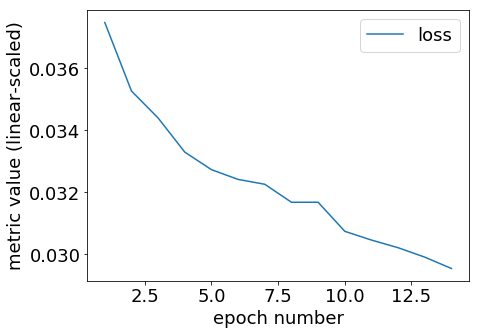

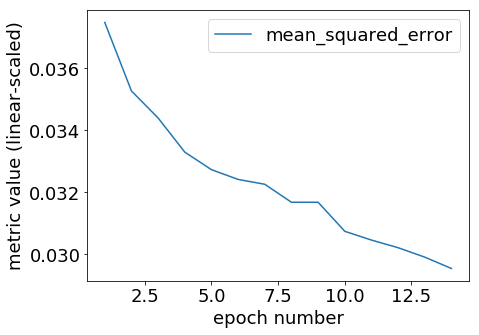

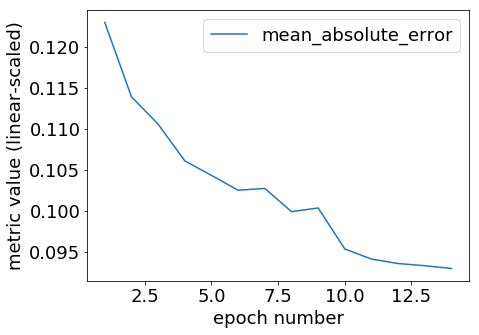

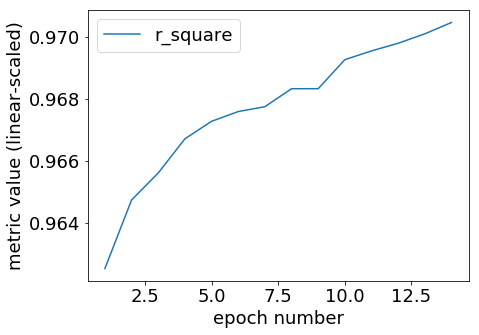

In [34]:
instance.plot_metrics(fnmatch_criteria="*loss*", yscale="linear")
instance.plot_metrics(fnmatch_criteria="*squared*", yscale="linear")
instance.plot_metrics(fnmatch_criteria="*absolute*", yscale="linear")
instance.plot_metrics(fnmatch_criteria="*r_square*", yscale="linear")


checking results:

84.05 % majority events
15.95 % outlier events
data_table :: plotting distrubution(s) for table(s) ['all jet data', 'all jet data (pred)', 'cleaned data']


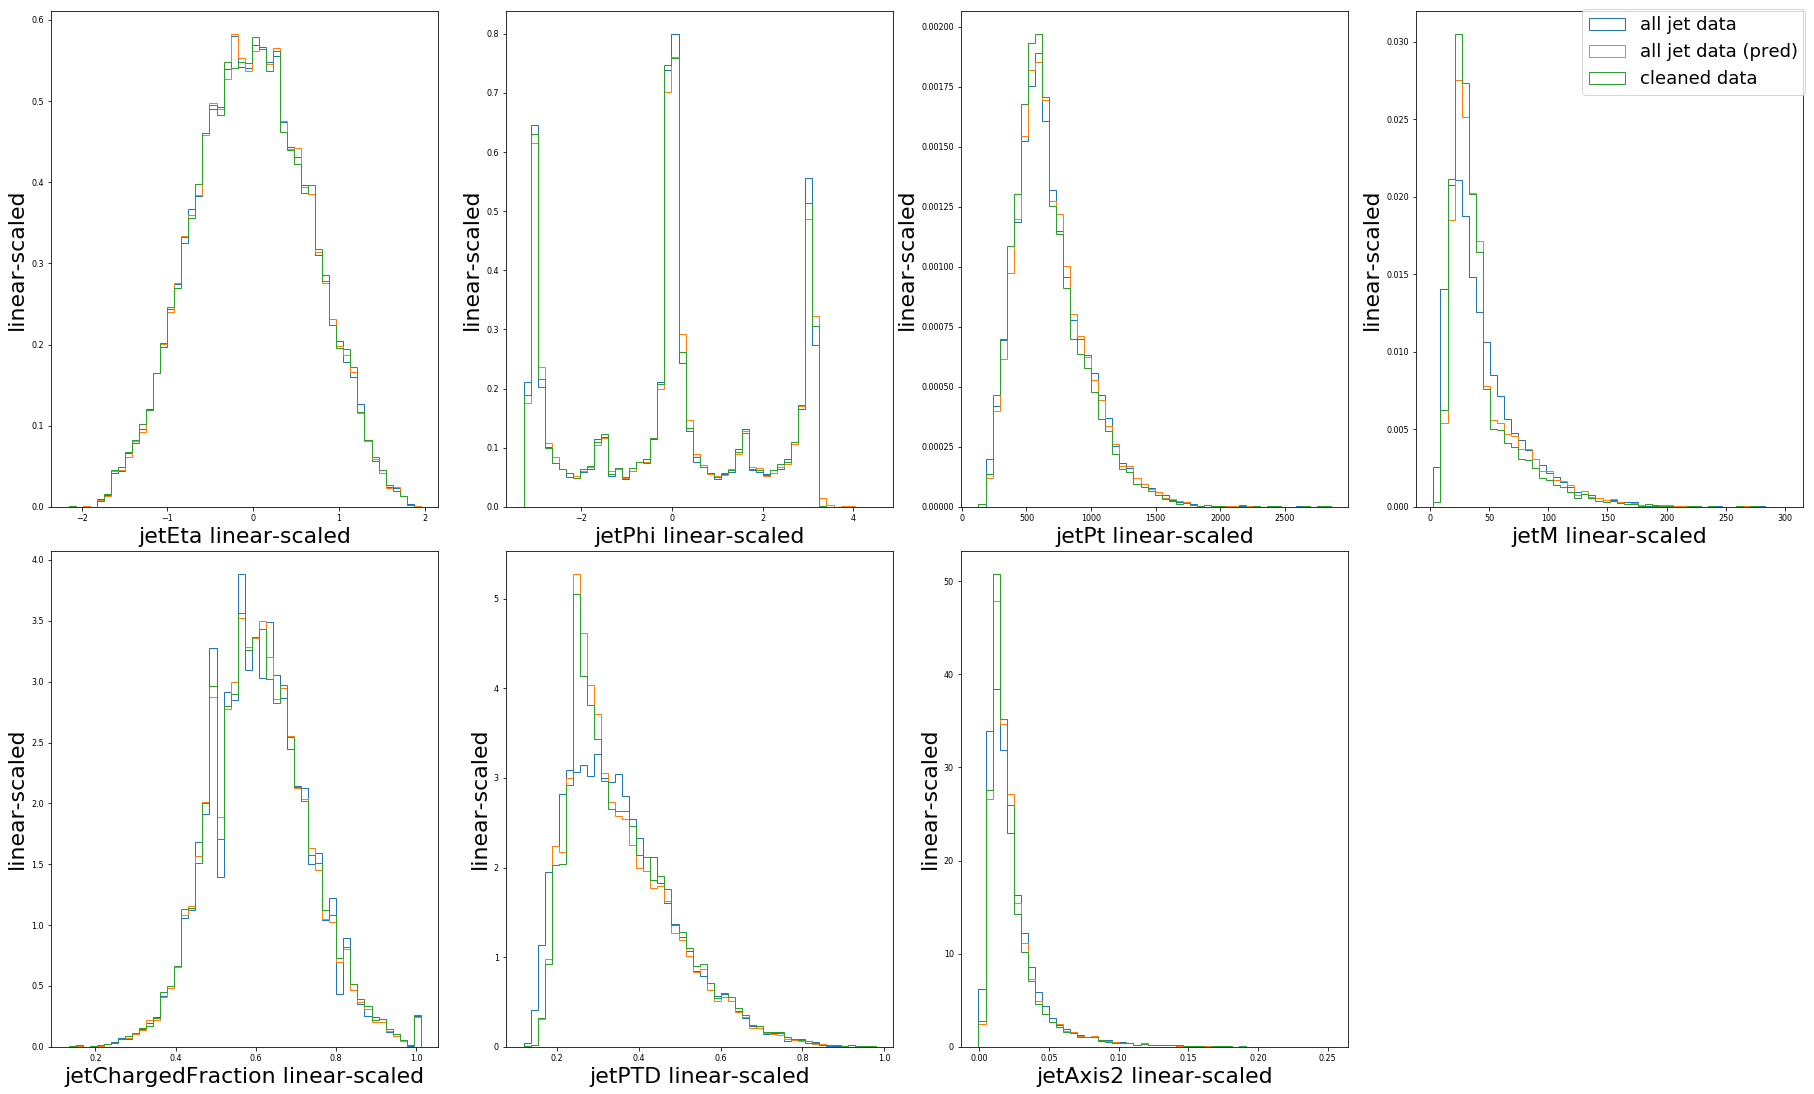

In [35]:
def binary_error(value):
    if value == 0.0:
        return 0 # 'majority'
    else:
        return 1 #'outlier'
    
predictions = np.asarray(list(map(binary_error,np.linalg.norm(robust.S,axis = 1))))
print("{:.2f} % majority events".format(100.*float(predictions[predictions == 0].size)/float(predictions.size)))
print("{:.2f} % outlier events".format(100.*float(predictions[predictions == 1].size)/float(predictions.size)))

data_recon_norm = utils.data_table(robust.predict(data.norm(**norm_args).df.values), headers=train_norm.headers)
data_recon = data.inorm(data_recon_norm, **norm_args)
data_recon.name = "all jet data (pred)"

train_clean = data.inorm(utils.data_table(robust.L[np.linalg.norm(robust.S, axis=1) == 0] , headers=data.headers, name="cleaned reconstructed data"), **norm_args)
train_clean.name = "cleaned data"
data.plot(
    [data_recon, train_clean],
    normed=1, bins=50,
    alpha=1.0, figloc="upper right",
    figsize=(25,15), fontsize=22
)

In [36]:
encoder, decoder = autoencoder.layers[1:]
train_reps, test_reps = (
    utils.data_table(encoder.predict(train_norm.data), name="train_reps"),
    utils.data_table(encoder.predict(test_norm.data), name="test_reps")
)

data_table :: plotting distrubution(s) for table(s) ['train_reps', 'test_reps']


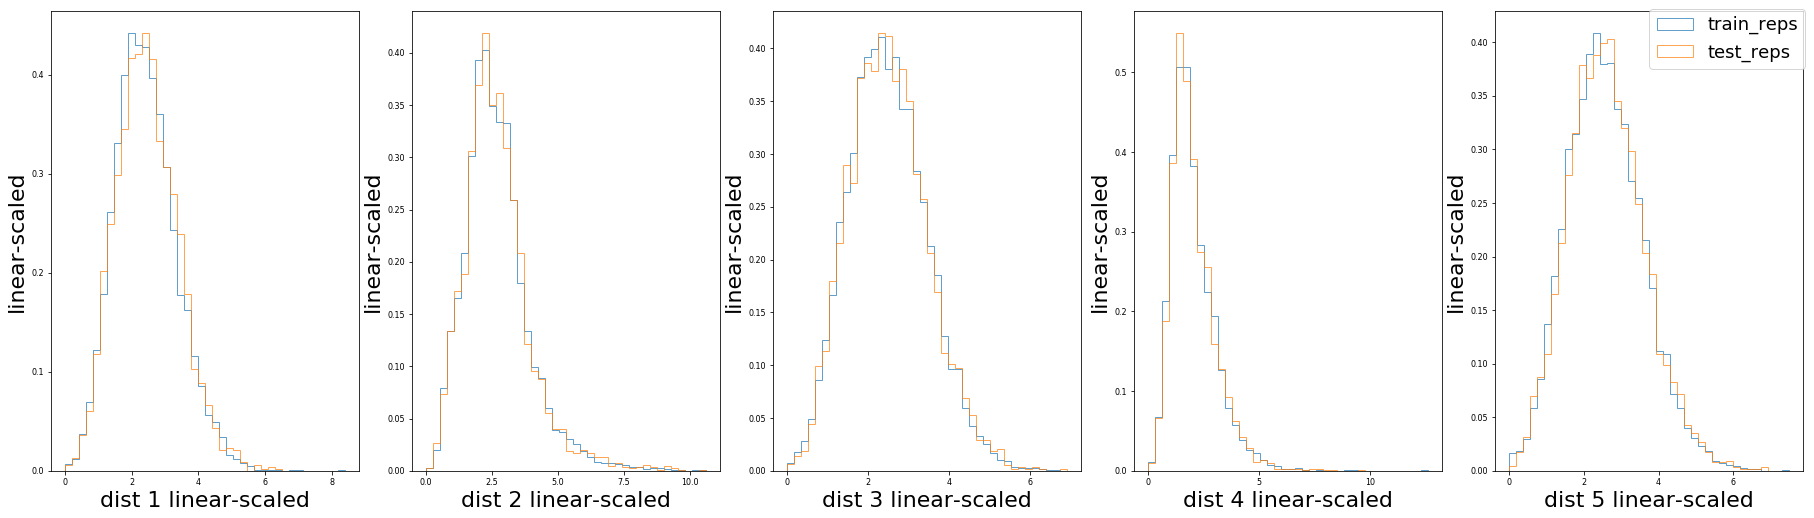

In [37]:
train_reps.plot([test_reps], cols=5, figsize=(25,7), fontsize=22, normed=1, bins=40)

In [38]:
print robust.L.shape
print robust.S.shape

(11236, 7)
(11236, 7)


data_table :: plotting distrubution(s) for table(s) ['cleaned data', 'all jet data (pred)']


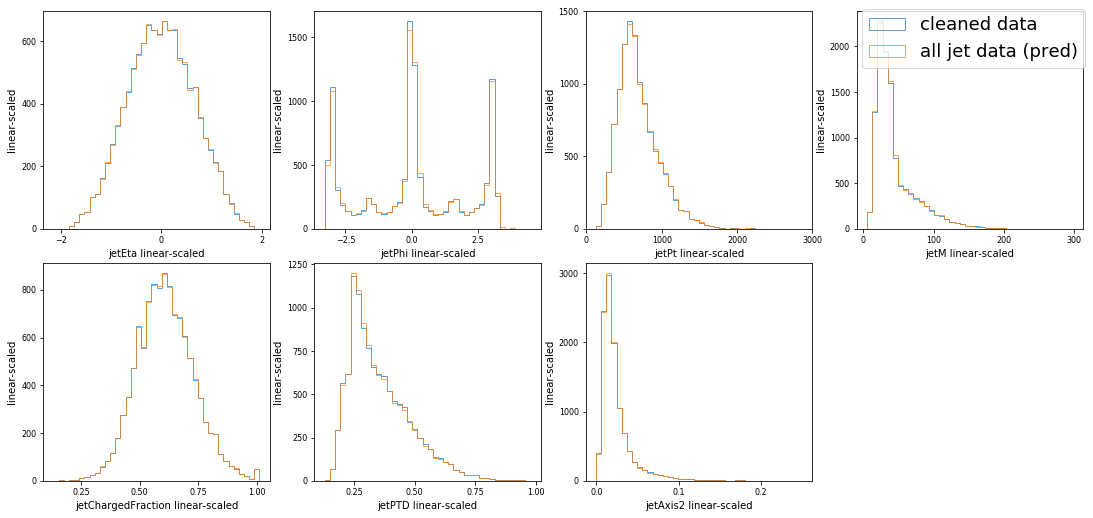

In [39]:
train_clean = data.inorm(utils.data_table(robust.L, headers=data.headers, name="cleaned reconstructed data"), **norm_args)
train_clean.name = "cleaned data"
train_clean.plot([data_recon], bins=40, figsize=(15,7))

In [300]:
import keras
errors = utils.data_table(np.asarray(map(
        lambda x: keras.backend.eval(getattr(keras.losses, x)(data.norm(**norm_args).data, data_recon_norm.data)),
        ["mse", "mae"]
    )).T,                      
    headers=["mse", "mae"],
    name="errors"
)

data_table :: plotting distrubution(s) for table(s) ['errors']


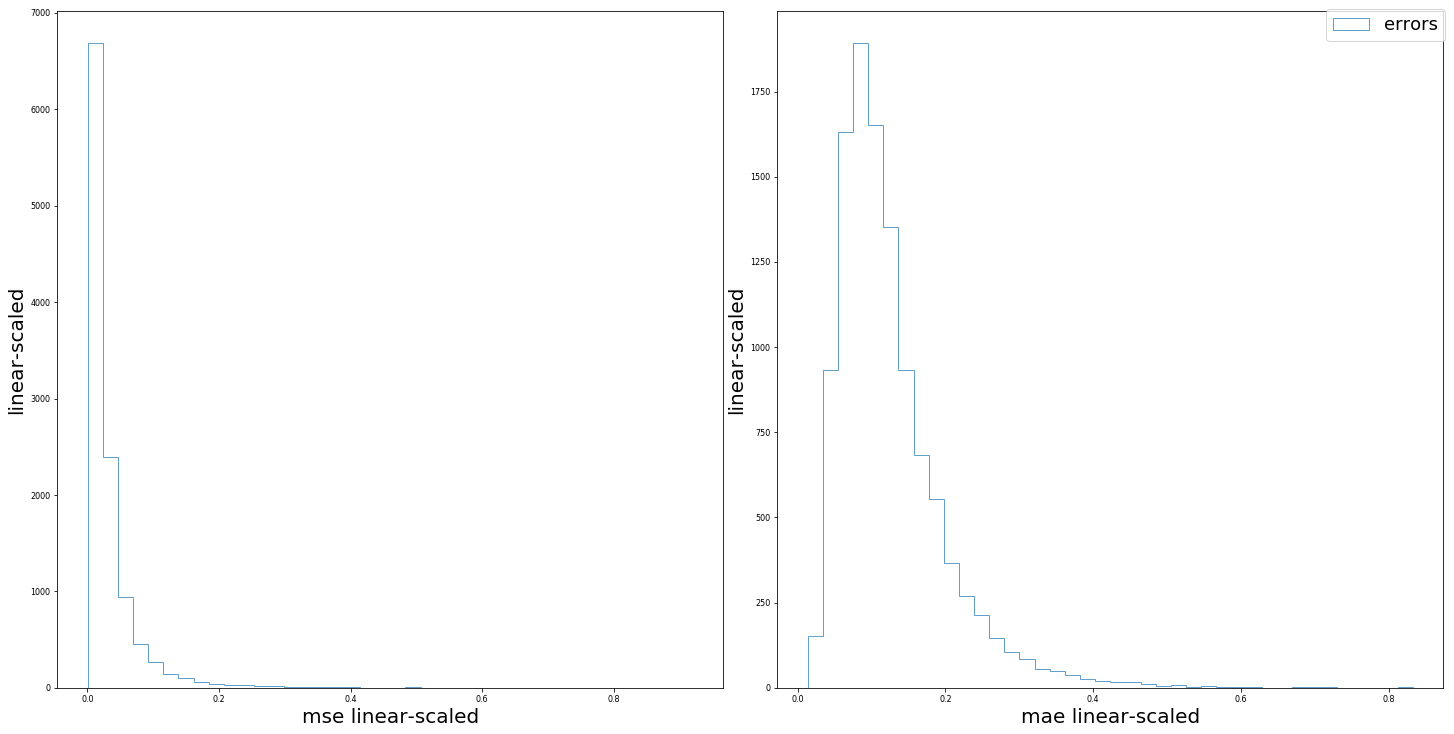

In [230]:
errors.plot(figsize=(20,10), bins=40, fontsize=20)

In [231]:
outlier_fraction = 0.01
index = np.argsort(errors.mae)
out_index = index[-int(outlier_fraction*len(errors)):]
reg_index = index[:-int(outlier_fraction*len(errors))]
print out_index.size + reg_index.size,len(errors)
print out_index.size, reg_index.size

11236 11236
112 11124


data_table :: plotting distrubution(s) for table(s) ['output data', 'non-outliers']


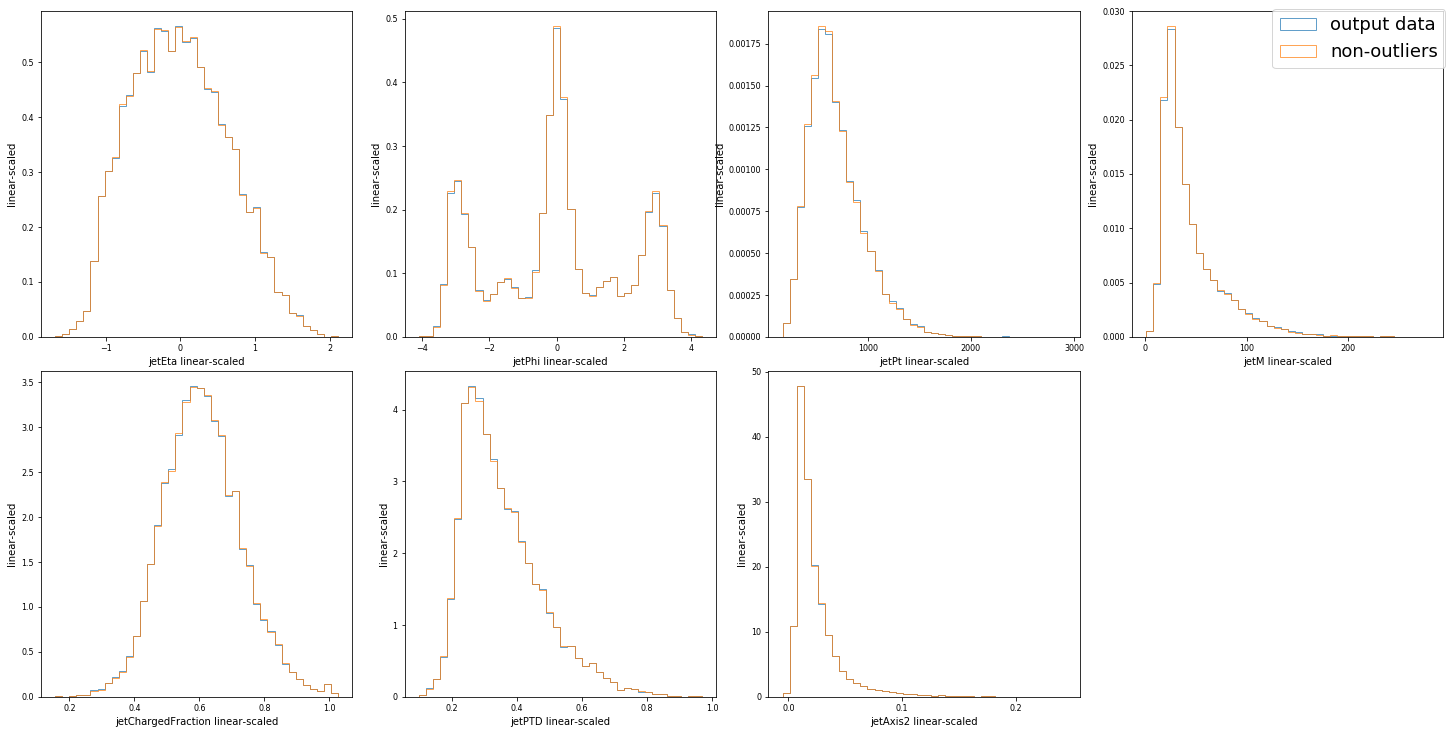

In [232]:
out,recon,reg = (
    utils.data_table(data_recon.data[out_index], headers=data.headers, name="outliers (top {})".format(outlier_fraction)), 
    utils.data_table(data_recon.data, headers=data.headers, name="output data".format(outlier_fraction)), 
    utils.data_table(data_recon.data[reg_index], headers=data.headers, name="non-outliers")
)
recon.plot([reg], normed=1, bins=40, figsize=(20,10))